In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from adjustText import adjust_text
import pickle
import warnings
warnings.filterwarnings('ignore')
import re
from matplotlib.backends.backend_pdf import PdfPages
from operator import concat
from functools import reduce

In [2]:
ts_df = pd.read_csv('./data/SWOW_prediction/eval/time_series/nyt_ts_df.csv')

ts_df = ts_df.groupby(['words','year','property'])[['outputs_z','count']].mean().reset_index()
ts_df = ts_df.loc[ts_df['count'] >= 50]

In [3]:
init_ts_df = pd.read_csv('./data/SWOW_prediction/eval/time_series/nyt_ts_df.csv')

init_ts_df = init_ts_df.groupby(['words','year','property'])[['outputs_z','count']].mean().reset_index()
init_ts_df = init_ts_df.loc[init_ts_df['count'] >= 50]

In [4]:
indexed_df = ts_df.set_index(['words']) #red: republicans, blue: democrats
elections = {1988:'tab:red', 1992:'tab:blue',1996:'tab:blue',2000:'tab:red',2004:'tab:red',2008:'tab:blue'}
blue_years = {year for year in elections if elections[year] == 'tab:blue'}
red_years = {year for year in elections if elections[year] == 'tab:red'}
blue_years, red_years

({1992, 1996, 2008}, {1988, 2000, 2004})

In [5]:
mapping = {'treati': 'treaty', 'salari': 'salary', 'judici': 'judiciary', 'poverti': 'poverty', 'navi': 'navy', 'militari': 'military', 'regulatori': 'regulatory', 'duti': 'duty', 'treasuri': 'treasury', 'recoveri': 'recovery', 'armi': 'army', 'freedeliveri': 'freedelivery', 'busi': 'business', 'privaci': 'privacy', 'bankruptci:': 'bankruptcy', 'safeti': 'safety', 'bureaucraci': 'bureaucracy', 'selfsuffici': 'selfsufficy', 'alreadi': 'already', 'bankruptci': 'bankruptcy', 'monetari': 'monetary', 'simplifi': 'simplify', 'germani': 'germany', 'subsidiari': 'subsidiary', 'secondari': 'secondary', 'machineri': 'machinery', 'mandatori': 'mandatory', 'migratori': 'migratory', 'fisheri': 'fishery', 'equiti': 'equity', 'postsecondari': 'postsecondary', 'discriminatori': 'discriminatory', 'penalti': 'penalty', 'forestri': 'forestry', 'difficulti': 'difficulty', 'elementari': 'elementary', 'pariti': 'parity', 'secretari': 'secretary', 'slurri': 'slurry', 'dairi': 'dairy', 'duli': 'duly', 'daili': 'daily', 'antipoverti': 'antipoverty', 'liberti': 'liberty', 'laboratori': 'laboratory', 'judiciari': 'judiciary', 'wealthi': 'wealthy', 'entiti': 'entity', 'faculti': 'faculty', 'conspiraci': 'conspiracy', 'surgeri': 'surgery', 'countri': 'country', 'realiti': 'reality', 'everi': 'every', 'smallbusi': 'smallbusy', 'energi': 'energy', 'discretionari': 'discretionary', 'ssi': 'ssy', 'societi': 'society', 'communiti': 'community', 'compensatori': 'compensatory', 'prioriti': 'priority', 'properti': 'property', 'liquefi': 'liquefy', 'democraci': 'democracy', 'deputi': 'deputy', 'revolutionari': 'revolutionary', 'beneficiari': 'beneficiary', 'qualiti': 'quality', 'jewri': 'jewry', 'enemi': 'enemy', 'compulsori': 'compulsory',\
 'economi':'econom',
 'polici':'policy',
 'famili':'family',
 'lobbi':'lobby',
 'bodi':'body',
 'victori':'victory',
 'theori':'theor',
    'countri':'country',
    'healthi':'health',
    'needi':'need',
    'primari':'primary',
    'studi':'stud',
    'territori':'territor',
    'voluntari':'voluntar',
    'deliveri':'delivery',
    'scrutini':'scrutiny',
    'necessari':'necessary',
    'philosophi':'philosoph',
    'juri':'jury',
    'speedi':'speedy',
    'basi':'basic',
    'treasuri':'treasury',
    
}

In [6]:
keyword_file = './data/hein-daily/keywords.txt'
topic_keywords = {}
one_grams = set()
with open(keyword_file) as f:
    lines = f.readlines()[1:]
    for line in lines:
        topic, word = line.split('|')
        word = word.strip()
        if word in mapping:
            word = mapping[word]
        
        topic_keywords[word] = topic.strip()
        one_grams.add(word)
    
len(topic_keywords),len(one_grams) #Let's not add bi-grams for now

(282, 282)

In [7]:
all_words = ts_df.words.unique()
prefix_mapping = dict()
political_one_grams = set()

In [8]:
bigram_file = './data/hein-daily/topic_phrases.txt'
bi_grams = set()
ending_with_i = set()
with open(bigram_file) as f:
    lines = f.readlines()[1:]
    for line in lines:
        topic, word = line.split('|')
        
        b1, b2 = word.split()
        topic_keywords[word.strip()] = topic.strip()
        b1 = b1.strip()
        b2 = b2.strip()
        if b1 in mapping:
            b1 = mapping[b1]
        if b2 in mapping:
            b2 = mapping[b2]
        

        if b1 not in prefix_mapping:
            
            prefix_mapping[b1] = [w for w in all_words if w.startswith(b1)]
            political_one_grams.update(set(prefix_mapping[b1]))
        if b2 not in prefix_mapping:
            
            prefix_mapping[b2] = [w for w in all_words if w.startswith(b2)]
            political_one_grams.update(set(prefix_mapping[b2]))
        for w1 in prefix_mapping[b1] :
            for w2 in prefix_mapping[b2]:
                bi_grams.add(w1 + ' ' + w2)
            
        
len(bi_grams)


191518

In [9]:
political_one_grams.update(one_grams)
small_ts_df = ts_df.loc[(ts_df.words.isin(political_one_grams)) |(ts_df.words.isin(bi_grams)) ]
small_ts_df = small_ts_df.set_index('words')
len(small_ts_df), len(ts_df)

(187770, 555064)

In [10]:
bi_gram_ts_df = pd.DataFrame()

In [11]:
with open(bigram_file) as f:
    lines = f.readlines()[1:]
    print(len(lines))
    for i, line in enumerate(lines):
        if i % 100 == 0:
            print(i, len(lines))
        
        topic, word = line.split('|')
        
        b1, b2 = word.split()
        b1 = b1.strip()
        b2 = b2.strip()
        if b1 in mapping:
            b1 = mapping[b1]
        if b2 in mapping:
            b2 = mapping[b2]
        
        
        
        b1_df = small_ts_df.loc[small_ts_df.index.isin(prefix_mapping[b1])].reset_index()
        
        b2_df = small_ts_df.loc[small_ts_df.index.isin(prefix_mapping[b2])].reset_index()
        
        if len(b1_df) == 0 or len(b2_df) == 0:
            continue
        b1_df = b1_df.groupby(['property','year'])[['count','outputs_z']].mean().reset_index()
        b2_df = b2_df.groupby(['property','year'])[['count','outputs_z']].mean().reset_index()
        
        joint_df = b1_df.set_index(['property','year']).\
        join(b2_df.set_index(['property','year']), lsuffix = '_1',rsuffix = '_2').\
        reset_index()
        joint_df['count'] = (joint_df['count_1'] + joint_df['count_2']) / 2
        joint_df['outputs_z'] = (joint_df['outputs_z_1'] + joint_df['outputs_z_2']) / 2
        joint_df['topic'] = topic
        joint_df['words'] = word.strip()
        
        bi_gram_ts_df = pd.concat((bi_gram_ts_df, joint_df),ignore_index = True)
        


7555
0 7555
100 7555
200 7555
300 7555
400 7555
500 7555
600 7555
700 7555
800 7555
900 7555
1000 7555
1100 7555
1200 7555
1300 7555
1400 7555
1500 7555
1600 7555
1700 7555
1800 7555
1900 7555
2000 7555
2100 7555
2200 7555
2300 7555
2400 7555
2500 7555
2600 7555
2700 7555
2800 7555
2900 7555
3000 7555
3100 7555
3200 7555
3300 7555
3400 7555
3500 7555
3600 7555
3700 7555
3800 7555
3900 7555
4000 7555
4100 7555
4200 7555
4300 7555
4400 7555
4500 7555
4600 7555
4700 7555
4800 7555
4900 7555
5000 7555
5100 7555
5200 7555
5300 7555
5400 7555
5500 7555
5600 7555
5700 7555
5800 7555
5900 7555
6000 7555
6100 7555
6200 7555
6300 7555
6400 7555
6500 7555
6600 7555
6700 7555
6800 7555
6900 7555
7000 7555
7100 7555
7200 7555
7300 7555
7400 7555
7500 7555


In [12]:
bi_gram_ts_df['words'] = bi_gram_ts_df['words'].apply(lambda w : w.strip())
bi_gram_ts_df = bi_gram_ts_df.dropna().reset_index(drop = True)

In [13]:
bigram_category = bi_gram_ts_df.groupby('topic')['words'].apply(list).to_dict()
small_ts_df = pd.concat((small_ts_df.reset_index(), bi_gram_ts_df[['words','year','property','count','outputs_z']]),ignore_index = True)
small_ts_df = small_ts_df.dropna().reset_index(drop = True)
len(small_ts_df)

489944

In [14]:
rest_df = ts_df.loc[~ts_df.words.isin(small_ts_df.words.unique())].reset_index()
len(rest_df)

367294

In [15]:
ts_df = pd.concat((small_ts_df, rest_df),ignore_index = True) #Filtering the timeseries df to include only the congressional speech keywords/key bigrams
words = ts_df.words.unique()

In [16]:
from pingouin import ttest as pttest

In [17]:
result = []
election_year_df = ts_df.loc[(ts_df.year.isin(elections.keys())) & (ts_df['count'] >= 50)]
no_election_year_df = ts_df.loc[~ts_df.year.isin(elections.keys())& (ts_df['count'] >= 50)]
ele_counts = election_year_df.groupby(['words','property']).outputs_z.count().to_dict()
no_ele_counts = no_election_year_df.groupby(['words','property']).outputs_z.count().to_dict()
ele_dict = election_year_df.groupby(['words','property']).outputs_z.mean().to_dict()
no_ele_dict = no_election_year_df.groupby(['words','property']).outputs_z.mean().to_dict()
for word in words:
    new_row = {'word':word}
    for pr in ['previous_link','polarity']:
        if (word,pr) in ele_dict and (word,pr) in no_ele_dict:
            if ele_counts[(word,pr)] >= 2 and no_ele_counts[(word,pr)] >= 2:
                new_row[f'{pr}_election'] = ele_dict[(word, pr)]
                new_row[f'{pr}_no_election'] = no_ele_dict[(word, pr)]
        else:
            continue
    result.append(new_row)

election_df = pd.DataFrame(result).drop_duplicates().dropna().reset_index(drop = True)
election_df['polarity_diff'] = election_df['polarity_election'] - election_df['polarity_no_election']
election_df['relevance_diff'] = election_df['previous_link_election'] - election_df['previous_link_no_election']
election_df['polarity_diff'] = (election_df['polarity_diff'] - election_df['polarity_diff'].mean()) / election_df['polarity_diff'].std()
election_df['relevance_diff'] = (election_df['relevance_diff'] - election_df['relevance_diff'].mean()) / election_df['relevance_diff'].std()


political_election_df = election_df.loc[election_df.word.isin(topic_keywords.keys())]
rest_election_df = election_df.loc[~election_df.word.isin(topic_keywords.keys())]

political_election_df['category'] = political_election_df.word.apply(lambda w: topic_keywords[w])



In [18]:
categories = political_election_df.category.unique()
categories

array(['foreign', 'minorities', 'alcohol', 'immigration', 'defense',
       'justice', 'elections', 'business', 'government', 'budget',
       'education', 'environment', 'health', 'money', 'religion', 'crime',
       'trade', 'labor', 'economy', 'federalism', 'mail', 'tax'],
      dtype=object)

In [19]:
result = []
blue_year_df = ts_df.loc[(ts_df.year.isin(blue_years)) & (ts_df['count'] >= 50)]
red_election_year_df = ts_df.loc[(ts_df.year.isin(red_years)) & (ts_df['count'] >= 50)]
ele_counts = blue_year_df.groupby(['words','property']).outputs_z.count().to_dict()
no_ele_counts = red_election_year_df.groupby(['words','property']).outputs_z.count().to_dict()
ele_dict = blue_year_df.groupby(['words','property']).outputs_z.mean().to_dict()
no_ele_dict = red_election_year_df.groupby(['words','property']).outputs_z.mean().to_dict()
for word in words:
    new_row = {'word':word}
    for pr in ['previous_link','polarity']:
        if (word,pr) in ele_dict and (word,pr) in no_ele_dict:
            if ele_counts[(word,pr)] >= 2 and no_ele_counts[(word,pr)] >= 2:
                new_row[f'{pr}_blue_election'] = ele_dict[(word, pr)]
                new_row[f'{pr}_red_election'] = no_ele_dict[(word, pr)]
        else:
            continue
    result.append(new_row)

party_election_df = pd.DataFrame(result).drop_duplicates().dropna().reset_index(drop = True)
party_election_df['polarity_diff'] = party_election_df['polarity_blue_election'] - party_election_df['polarity_red_election']
party_election_df['relevance_diff'] = party_election_df['previous_link_blue_election'] - party_election_df['previous_link_red_election']


party_election_df['polarity_diff'] = (party_election_df['polarity_diff'] - party_election_df['polarity_diff'].mean()) / party_election_df['polarity_diff'].std()
party_election_df['relevance_diff'] = (party_election_df['relevance_diff'] - party_election_df['relevance_diff'].mean()) / party_election_df['relevance_diff'].std()



In [20]:
political_df = party_election_df.loc[party_election_df.word.isin(topic_keywords.keys())]
political_df['category'] = political_df.word.apply(lambda w: topic_keywords[w])

In [21]:
first_df = political_df.copy(deep = True)
political_df = political_df.drop('word',axis = 1).drop_duplicates().dropna().reset_index(drop = True)

compare_df = political_df.loc[political_df.category == 'federalism'].dropna()
(compare_df['previous_link_blue_election'] - compare_df['previous_link_red_election']).mean(), (compare_df.relevance_diff.mean())

(0.08259145712167912, 0.6956210672038443)

In [24]:
from statsmodels.stats.multitest import multipletests

In [25]:
result = []
for category in categories:
    
    
    compare_df = political_df.loc[political_df.category == category].dropna()
    t, p = (stats.ttest_rel(compare_df['previous_link_blue_election'].values,compare_df['previous_link_red_election'].values))
   
    result.append({
        'Category':category,
        'n': len(compare_df),
        't': t,
        'p': p,
        'property':'relevance',
        'category':category,
        'blue': compare_df['previous_link_blue_election'].values.mean(),
        'red': compare_df['previous_link_red_election'].values.mean(),
        'difference': (compare_df['previous_link_blue_election'].values - compare_df['previous_link_red_election'].values).mean()
    })

for category in categories:
    
    
    compare_df = political_df.loc[political_df.category == category].dropna()
    t, p = (stats.ttest_rel(compare_df['polarity_blue_election'].values,compare_df['polarity_red_election'].values))
    
    result.append({
        'Category':category,
        'n': len(compare_df),
        't': t,
        'p': p,
        'property':'polarity',
        'category':category,
        'blue': compare_df['polarity_blue_election'].values.mean(),
        'red': compare_df['polarity_red_election'].values.mean(),
        'difference': (compare_df['polarity_blue_election'].values - compare_df['polarity_red_election'].values).mean()
    })
    

In [26]:
result = pd.DataFrame(result)
relevance_df = result.loc[result.property == 'relevance']
polarity_df = result.loc[result.property == 'polarity']
relevance_df['reject'] = multipletests(relevance_df['p'],method = 'bonferroni')[0]
relevance_df['correct_p']= multipletests(relevance_df['p'],method = 'bonferroni')[1]


polarity_df['reject'] = multipletests(polarity_df['p'],method = 'bonferroni')[0]
polarity_df['correct_p']= multipletests(polarity_df['p'],method = 'bonferroni')[1]
relevance_df['Category'] = [c + ' (n = {})'.format(n)  for c, n in zip(relevance_df.Category, relevance_df.n)]
relevance_df['hue'] = relevance_df['t'].apply(lambda t: t < 0)


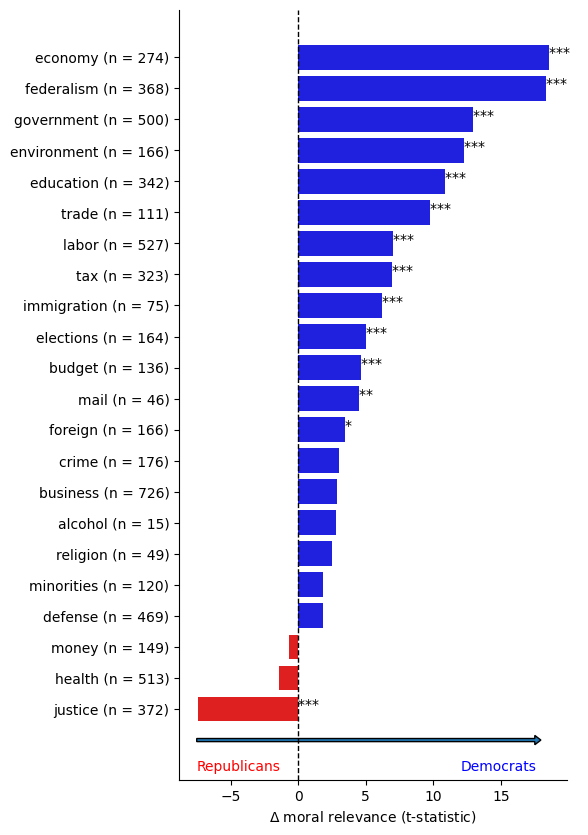

In [27]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(y='Category', 
            x='t', 
            data=relevance_df.sort_values(by = 't',ascending = False),
            hue = 'hue',
            ax = ax, palette={"blue","red"})

ax.legend_ = None
ax.axvline(0, color='black', linewidth=1, linestyle='--')
for i, row in relevance_df.sort_values(by = 't',ascending = False).iterrows():
    star = ''
    if row['reject'] == True:
        if row['correct_p'] < 0.001:
            star = '***  '
        elif row['correct_p'] < 0.01:
            star = '**  '
        elif row['correct_p'] < 0.05:
            star = '*  '
    # star += 'n = ' + str(row['n'])
    
    ax.text(y = row['Category'], x = max(0, row['t']), s = star)

ax.set_ylabel('')
ax.arrow(-7.5,22, 25,  0,width = 0.1)
ax.text(x = -7.5, y = 23, s = 'Republicans',color = 'red',)
ax.text(x = 12, y = 23, s = 'Democrats',color = 'blue',)
ax.set_xlabel(u'$\Delta$ moral relevance (t-statistic)')



sns.despine()
# plt.savefig('notebooks/figs/nyt_party_election_topic_sig.pdf',dpi = 400, bbox_inches = 'tight')
plt.show()


In [29]:
plot_df = first_df.copy(deep = True)
plot_df['bigram'] = plot_df.word.apply(lambda x: x if len(x.split()) == 1 else ",".join(sorted(x.split())))
bigram_map = plot_df.groupby('bigram').word.apply(list).to_dict()
columns = list(plot_df.columns)
columns.remove('word')
columns.remove('bigram')
columns.remove('category')
plot_df = plot_df.groupby(['bigram','category'])[columns].mean().reset_index()
plot_df['word'] = plot_df['bigram'].apply(lambda w:bigram_map[w][0] )

plot_df = plot_df.loc[(plot_df.previous_link_red_election > 0) | (plot_df.previous_link_blue_election > 0)]

k = 15
df1 = plot_df.loc[(plot_df.word.isin(political_one_grams)) |(plot_df.word.isin(bi_grams)) ].\
sort_values(by = 'relevance_diff',ascending = False).head(k)
plot_df = pd.concat((df1,  plot_df.loc[(plot_df.word.isin(political_one_grams)) |(plot_df.word.isin(bi_grams)) ]\
                     .sort_values(by = 'relevance_diff',ascending = True).head(k)),ignore_index = True)


plot_df['word'] = plot_df['word'].apply(lambda w: w.replace('americ','Americ').replace('african','African').\
                                        replace('hiv','HIV').\
                                        replace('silver silver','silver').\
                                        replace('iran','Iran').replace('china','China').\
                                        replace('hindu','Hindu').replace('cuba','Cuba').replace('saddam','Saddam').\
                                        replace('hussein','Hussein'))
plot_df = plot_df.sort_values(by = 'relevance_diff').reset_index()

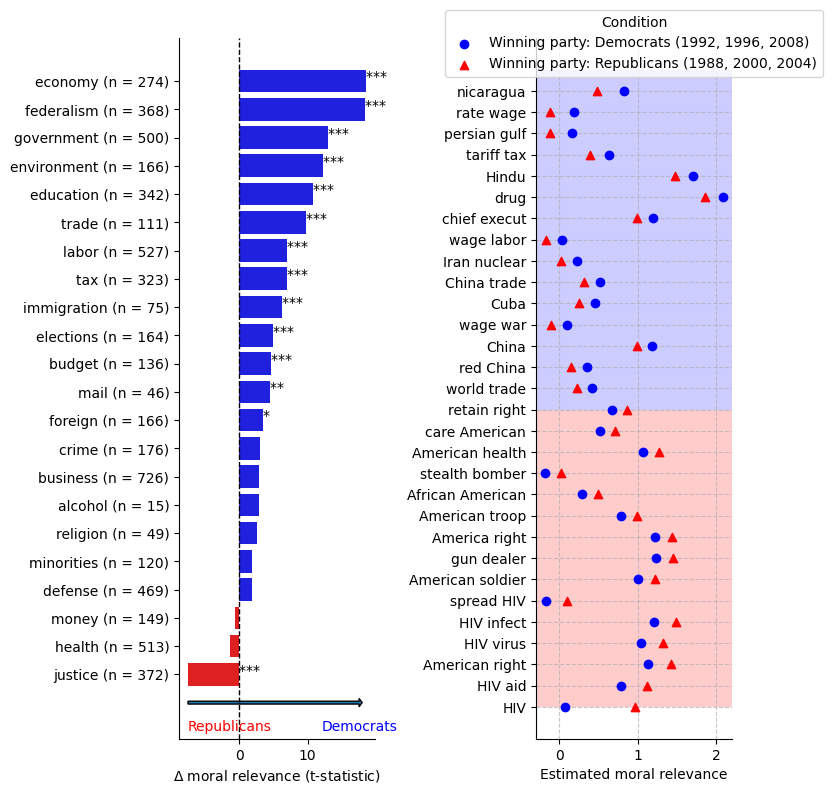

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes[0]
sns.barplot(y='Category', 
            x='t', 
            data=relevance_df.sort_values(by = 't',ascending = False),
            hue = 'hue',
            ax = ax, palette={"blue","red"})

ax.legend_ = None
ax.axvline(0, color='black', linewidth=1, linestyle='--')
for i, row in relevance_df.sort_values(by = 't',ascending = False).iterrows():
    star = ''
    if row['reject'] == True:
        if row['correct_p'] < 0.001:
            star = '***  '
        elif row['correct_p'] < 0.01:
            star = '**  '
        elif row['correct_p'] < 0.05:
            star = '*  '
    # star += 'n = ' + str(row['n'])
    
    ax.text(y = row['Category'], x = max(0, row['t']), s = star)

ax.set_ylabel('')
ax.arrow(-7.5,22, 25,  0,width = 0.1)
ax.text(x = -7.5, y = 23, s = 'Republicans',color = 'red',)
ax.text(x = 12, y = 23, s = 'Democrats',color = 'blue',)
ax.set_xlabel(u'$\Delta$ moral relevance (t-statistic)')
sns.despine()
ax = axes[1]




span_1 = plot_df.loc[plot_df.relevance_diff > 0]
ax.axhspan(0, len(span_1) - 1, facecolor=f'red', alpha=0.2)
ax.axhspan(len(span_1) - 1, len(plot_df), facecolor=f'blue', alpha=0.2)

ax.scatter(y = plot_df.word, x = plot_df['previous_link_blue_election'], 
            color='blue', label='Winning party: Democrats (1992, 1996, 2008)', zorder=3,
          marker = 'o')
ax.scatter(y = plot_df.word, x = plot_df['previous_link_red_election'], 
            color='red', label='Winning party: Republicans (1988, 2000, 2004)', 
           marker = '^',zorder=3)


ax.set_xlabel('Estimated moral relevance')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(title='Condition',loc = 'upper center',bbox_to_anchor = (0.5, 1.05))

# Show the plot
plt.tight_layout()
# plt.savefig('notebooks/figs/nyt_party_election_both.pdf',dpi = 300, bbox_inches = 'tight')
plt.show()
